

#### Import libraries



In [ ]:
import os
import shutil
import subprocess as sp
import json
import pathlib
import urllib.request
import itertools
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torchvision
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda








---


# Модель 0. Неудачный вариант YOLO на всех классах (не использовал)










## Download files





In [ ]:
# mtsd_fully_annotated_annotation.zip
#!wget 'https://scontent.ftbs2-2.fna.fbcdn.net/m1/v/t6/An90x89nHvauCK1fqMJ8110KeTjNo5Si7rzhvwIMCu5xI9_GhWBGOIXaFvu6o53NuNpBMzdC9qsjAVR8sLv8m6WoFfn6Qd4NjMYKNW4NCKVp6gx3MhZtwf3cZR94wFhou5lPI0hGUw.zip?ccb=10-5&oh=00_AfAy1krcOV797mC-XqGT2z2K-ZGvmW_25HIJlNFHdhasCA&oe=63F4CB88&_nc_sid=a6c829'
#!unzip 'An90x89nHvauCK1fqMJ8110KeTjNo5Si7rzhvwIMCu5xI9_GhWBGOIXaFvu6o53NuNpBMzdC9qsjAVR8sLv8m6WoFfn6Qd4NjMYKNW4NCKVp6gx3MhZtwf3cZR94wFhou5lPI0hGUw.zip?ccb=10-5&oh=00_AfAy1krcOV797mC-XqGT2z2K-ZGvmW_25HIJlNFHdhasCA&oe=63F4CB88&_nc_sid=a6c829'
#!rm 'An90x89nHvauCK1fqMJ8110KeTjNo5Si7rzhvwIMCu5xI9_GhWBGOIXaFvu6o53NuNpBMzdC9qsjAVR8sLv8m6WoFfn6Qd4NjMYKNW4NCKVp6gx3MhZtwf3cZR94wFhou5lPI0hGUw.zip?ccb=10-5&oh=00_AfAy1krcOV797mC-XqGT2z2K-ZGvmW_25HIJlNFHdhasCA&oe=63F4CB88&_nc_sid=a6c829'

# mtsd_fully_annotated_images.test.zip
# !wget 'https://scontent.ftbs2-2.fna.fbcdn.net/m1/v/t6/An9eB8zXYW473CiQYW9CPvGx1Ho-fkQvkini3ddExpFOz47aWs4ydBSvK-ZhOPu7ikASQmZvX0zyXhmJzBr6CDZE5ZkUhvJ44h7mV2NT4cSRbR837J9mHJosreQRJJdGaVDR26EAjLPL.zip?ccb=10-5&oh=00_AfCxuYEVlytXGOqRuqXE77ZJxHwx4c3GvHCCiXXbpMK1eA&oe=63F4D51C&_nc_sid=a6c829'
# !unzip 'An9eB8zXYW473CiQYW9CPvGx1Ho-fkQvkini3ddExpFOz47aWs4ydBSvK-ZhOPu7ikASQmZvX0zyXhmJzBr6CDZE5ZkUhvJ44h7mV2NT4cSRbR837J9mHJosreQRJJdGaVDR26EAjLPL.zip?ccb=10-5&oh=00_AfCxuYEVlytXGOqRuqXE77ZJxHwx4c3GvHCCiXXbpMK1eA&oe=63F4D51C&_nc_sid=a6c829'
# !rm 'An9eB8zXYW473CiQYW9CPvGx1Ho-fkQvkini3ddExpFOz47aWs4ydBSvK-ZhOPu7ikASQmZvX0zyXhmJzBr6CDZE5ZkUhvJ44h7mV2NT4cSRbR837J9mHJosreQRJJdGaVDR26EAjLPL.zip?ccb=10-5&oh=00_AfCxuYEVlytXGOqRuqXE77ZJxHwx4c3GvHCCiXXbpMK1eA&oe=63F4D51C&_nc_sid=a6c829'

# mtsd_fully_annotated_images.train.0.zip
# !wget 'https://scontent.ftbs2-2.fna.fbcdn.net/m1/v/t6/An_WKGcw-ICowA_xAgTEU_E-pAYdybyzT-9Pwi8JtelanWnNRKONV1DTAZPEAsGNDWlFpYDi16km1stDN47ip-quE77cfkv3aERdMIRahysGgspb6DlCgrabPSTFJI3tZ9EMRatRC6ZmjQytVcY.zip?ccb=10-5&oh=00_AfBARnn95ghRJHFvnLouq8a1TTEIQDxX_7Ss91i6Xll2dA&oe=63F4D172&_nc_sid=a6c829'
# !unzip 'An_WKGcw-ICowA_xAgTEU_E-pAYdybyzT-9Pwi8JtelanWnNRKONV1DTAZPEAsGNDWlFpYDi16km1stDN47ip-quE77cfkv3aERdMIRahysGgspb6DlCgrabPSTFJI3tZ9EMRatRC6ZmjQytVcY.zip?ccb=10-5&oh=00_AfBARnn95ghRJHFvnLouq8a1TTEIQDxX_7Ss91i6Xll2dA&oe=63F4D172&_nc_sid=a6'
# !rm 'An_WKGcw-ICowA_xAgTEU_E-pAYdybyzT-9Pwi8JtelanWnNRKONV1DTAZPEAsGNDWlFpYDi16km1stDN47ip-quE77cfkv3aERdMIRahysGgspb6DlCgrabPSTFJI3tZ9EMRatRC6ZmjQytVcY.zip?ccb=10-5&oh=00_AfBARnn95ghRJHFvnLouq8a1TTEIQDxX_7Ss91i6Xll2dA&oe=63F4D172&_nc_sid=a6'

# mtsd_fully_annotated_images.train.1.zip
# !wget 'https://scontent.ftbs2-2.fna.fbcdn.net/m1/v/t6/An8VtaI-ldaSOc5HcLFVQ6SPvHDt50hLG1kga0nUfswldLu1J9dsOx6ynZicRUuXR_TvsczpplOqQEa7ppT4JwUzI0ZNQCHmhtkfT5tjdNJY55Ud6eXplvq59PjOx55d2EbIxYpO9vhR-BcflQ.zip?ccb=10-5&oh=00_AfDvkqMiY6bSxI3itOQyYXEa8pBrdC_mjrV3WLDIpHvc2g&oe=63F4E35E&_nc_sid=a6c829'
# !unzip 'An8VtaI-ldaSOc5HcLFVQ6SPvHDt50hLG1kga0nUfswldLu1J9dsOx6ynZicRUuXR_TvsczpplOqQEa7ppT4JwUzI0ZNQCHmhtkfT5tjdNJY55Ud6eXplvq59PjOx55d2EbIxYpO9vhR-BcflQ.zip?ccb=10-5&oh=00_AfDvkqMiY6bSxI3itOQyYXEa8pBrdC_mjrV3WLDIpHvc2g&oe=63F4E35E&_nc_sid=a6c'
# !rm 'An8VtaI-ldaSOc5HcLFVQ6SPvHDt50hLG1kga0nUfswldLu1J9dsOx6ynZicRUuXR_TvsczpplOqQEa7ppT4JwUzI0ZNQCHmhtkfT5tjdNJY55Ud6eXplvq59PjOx55d2EbIxYpO9vhR-BcflQ.zip?ccb=10-5&oh=00_AfDvkqMiY6bSxI3itOQyYXEa8pBrdC_mjrV3WLDIpHvc2g&oe=63F4E35E&_nc_sid=a6c'

# mtsd_fully_annotated_images.train.2.zip
# !wget 'https://scontent.ftbs2-2.fna.fbcdn.net/m1/v/t6/An9BwhO8zTAy6jGrwy71BjIBtMK8K5RkpIJguP7DVnpJK2TfKDlfxXj8mCxRJss4zzfaaKi2idqbQOtYJ740TPCI7w7hL8V7goknzuO0ZFPLywDCKIB7i64lCiSUNYXLqeS8mC7EkiU5hYAfOcI.zip?ccb=10-5&oh=00_AfDHsCH9F-dyG1PXhspRvP2GgCAh_Y_dU4Dm3M7K99Qi8g&oe=63F4CCDB&_nc_sid=a6c829'
# !unzip 'An9BwhO8zTAy6jGrwy71BjIBtMK8K5RkpIJguP7DVnpJK2TfKDlfxXj8mCxRJss4zzfaaKi2idqbQOtYJ740TPCI7w7hL8V7goknzuO0ZFPLywDCKIB7i64lCiSUNYXLqeS8mC7EkiU5hYAfOcI.zip?ccb=10-5&oh=00_AfDHsCH9F-dyG1PXhspRvP2GgCAh_Y_dU4Dm3M7K99Qi8g&oe=63F4CCDB&_nc_sid=a6'
# !rm 'An9BwhO8zTAy6jGrwy71BjIBtMK8K5RkpIJguP7DVnpJK2TfKDlfxXj8mCxRJss4zzfaaKi2idqbQOtYJ740TPCI7w7hL8V7goknzuO0ZFPLywDCKIB7i64lCiSUNYXLqeS8mC7EkiU5hYAfOcI.zip?ccb=10-5&oh=00_AfDHsCH9F-dyG1PXhspRvP2GgCAh_Y_dU4Dm3M7K99Qi8g&oe=63F4CCDB&_nc_sid=a6'

# mtsd_fully_annotated_images.val.zip
# !wget 'https://scontent.ftbs2-2.fna.fbcdn.net/m1/v/t6/An9tl3SwDwRFQ2z9tAag26brYamdQZmHnVoxfNTz_Iass-zZLWM-HryqW44UeqbLWd-EkXVIP-ZQQfg3F7dmQYlnu1wjzCARviaJMBHgtLH4gTAeW6msFbEXA3_NIZBtdP7Gg8dt5Ewl.zip?ccb=10-5&oh=00_AfBIIJqgcK-lzEX_jHm5YuK1P0Ww6NYL5vIhhuKvbftrVA&oe=63F4EC67&_nc_sid=a6c829'
# !unzip 'An9tl3SwDwRFQ2z9tAag26brYamdQZmHnVoxfNTz_Iass-zZLWM-HryqW44UeqbLWd-EkXVIP-ZQQfg3F7dmQYlnu1wjzCARviaJMBHgtLH4gTAeW6msFbEXA3_NIZBtdP7Gg8dt5Ewl.zip?ccb=10-5&oh=00_AfBIIJqgcK-lzEX_jHm5YuK1P0Ww6NYL5vIhhuKvbftrVA&oe=63F4EC67&_nc_sid=a6c829'
# !rm 'An9tl3SwDwRFQ2z9tAag26brYamdQZmHnVoxfNTz_Iass-zZLWM-HryqW44UeqbLWd-EkXVIP-ZQQfg3F7dmQYlnu1wjzCARviaJMBHgtLH4gTAeW6msFbEXA3_NIZBtdP7Gg8dt5Ewl.zip?ccb=10-5&oh=00_AfBIIJqgcK-lzEX_jHm5YuK1P0Ww6NYL5vIhhuKvbftrVA&oe=63F4EC67&_nc_sid=a6c829'






## Convert Mapillary Traffic Sign annotations to YOLO

Convert Mapillary Traffic Sign Dataset annotations from their native JSON format to the txt files used by Darknet/YOLO.

In [ ]:
def from_json(json_file):
    """Create a flat dataframe from a JSON file."""

    json_file = pathlib.Path(json_file)  # In case the file path is passed as a string

    # Load json as a regular python dict
    data = json.loads(json_file.read_bytes())

    # pandas.json_normalize drops items whose record_path points to an empty list
    if not data['objects']:
        data['objects'] = [{}]  # Now the list contains an empty dict (record)

    # Create a dataframe where each line correspons to one annotation
    df = pd.json_normalize(data, 
                           record_path=['objects'],
                           meta=['ispano', 'width', 'height'])

    # Add file name (without extension) as a column and return resulting dataframe
    return df.assign(image=json_file.stem)

In [ ]:
def to_yolo(df):
    """Convert annotations in dataframe to YOLO format."""

    new_df = pd.concat((
        df['image'],                                            # image file name
        df['label'].cat.codes,                                  # class id (number)
        df[['xmin', 'xmax']].mean(axis=1),                      # centroid x = (xmin+xmax)/2
        df[['ymin', 'ymax']].mean(axis=1),                      # centroid y = (ymin+ymax)/2
        df[['xmax', 'ymax']] - df[['xmin', 'ymin']].to_numpy()  # box width and height
    ), axis=1)

    new_df.columns = ['image', 'class', 'xc', 'yc', 'w', 'h']

    # Normalize calculated values to the image's width and height
    new_df[['xc', 'w']] = new_df[['xc', 'w']].div(df['width'], axis=0)
    new_df[['yc', 'h']] = new_df[['yc', 'h']].div(df['height'], axis=0)

    return new_df

#### Set input (JSON) and output (txt) directories

#### New section

In [ ]:
!mkdir -p '/content/drive/MyDrive/project/model1/labels/train' '/content/drive/MyDrive/project/model1/labels/test' '/content/drive/MyDrive/project/model1/labels/val'
!mkdir -p '/content/drive/MyDrive/project/model1/images/train' '/content/drive/MyDrive/project/model1/images/test' '/content/drive/MyDrive/project/model1/images/val'

In [ ]:
input_dir = pathlib.Path('/content/drive/MyDrive/project/mtsd_v2_fully_annotated/json_annotations')
#output_dir = pathlib.Path('/content/drive/MyDrive/project/dataset/labels') 
output_dir = pathlib.Path('/content/drive/MyDrive/project/model1/labels') 

#### Create a single dataframe with the whole set

Concatenate the dataframes returned by function from_json for each json file.

In [ ]:
df = pd.concat(map(from_json, input_dir.glob('*.json')), ignore_index=True)

# Converting column 'label' to type pandas.CategoricalDtype
# makes it easier to get a numerical representation for each label
df = df.astype({'label': 'category'})

# Remove prefixes added by pandas.json_normalize when flattening the original json object
for prefix in ('bbox.', 'properties.'):
    # df.columns = [c.removeprefix(prefix) for c in df.columns]  # removeprefix: Python 3.9+ only
    df.columns = [c[len(prefix):] if c.startswith(prefix) else c for c in df.columns]

df

ValueError: ignored

In [ ]:
#df.to_csv('sign_df_with_ann')
df = pd.read_csv('/content/drive/MyDrive/project/sign_df_with_ann.csv').astype({'label': 'category'})

#### Save a classes.txt file containing the labels for every class.

YOLO format represents each class by a numeric id, so the actual labels must be in a separate file.

A description of the class labels can be found here.

In [ ]:
with open(output_dir / 'classes.txt', 'w') as f:
    f.write('\n'.join(df['label'].cat.categories))

Create a txt with classes to export to yaml file.

In [ ]:
cd /content/drive/MyDrive/project/dataset/labels

d = {}
with open('classes.txt') as f:
    for n, line in enumerate(f):
        d[n] = str(n)+': '+str(line)
df = pd.Series(d)

cd /content/drive/MyDrive/project/dataset

with open('exported_classes.txt', 'w') as f:
    f.write(''.join(df))

#### Generate dataframe representing annotations in YOLO format.

The first column is the file name. Only the 5 remaining columns are written into YOLO annotation files.

In [ ]:
df_yolo = to_yolo(df)
df_yolo

,image,class,xc,yc,w,h
0,Rs8O3ZMrKQzIf_1TRwktTQ,139,0.634033,0.580444,0.014160,0.017822
1,Rs8O3ZMrKQzIf_1TRwktTQ,139,0.409302,0.590210,0.012939,0.017822
2,Rs8O3ZMrKQzIf_1TRwktTQ,109,0.634277,0.599365,0.013672,0.018555
3,Rs8O3ZMrKQzIf_1TRwktTQ,230,0.564575,0.610962,0.006592,0.008545
4,Rs8O3ZMrKQzIf_1TRwktTQ,109,0.409546,0.610596,0.013428,0.018555
...,...,...,...,...,...,...
206512,5VmsitTHKgZRcdJrmVZV4g,29,0.581299,0.759644,0.014160,0.019287
206513,5VmsitTHKgZRcdJrmVZV4g,89,0.541382,0.759644,0.012939,0.011475
206514,5VmsitTHKgZRcdJrmVZV4g,89,0.449341,0.764893,0.013428,0.010742
206515,5VmsitTHKgZRcdJrmVZV4g,89,0.430786,0.764160,0.009521,0.008789


#### Save converted data

One txt file per image.

In [ ]:
for image_name, group in df_yolo.groupby('image'):
    path = output_dir / f'{image_name}.txt'

    # If there are annotations for this image, dump them into the file
    if (group['class'] != -1).any():
        group.drop('image', axis=1).to_csv(path, sep=' ', header=False, index=False)
    else:
        path.touch()  # Create empty file

print(len(list(output_dir.glob('*.txt'))), 'txt files in output directory')

KeyboardInterrupt: ignored


## Move train/test/val files to the correspondong folder

In [ ]:
# Folder containing the files to be moved
source_folder = '/content/drive/MyDrive/project/model1/labels'

# Folder to move the files to
destination_train_folder = '/content/drive/MyDrive/project/model1/labels/train'
destination_test_folder = '/content/drive/MyDrive/project/model1/labels/test'
destination_val_folder = '/content/drive/MyDrive/project/model1/labels/val'

# File containing the names of files to be moved
file_with_train = 'drive/MyDrive/project/dataset/splits/train.txt'
file_with_test = 'drive/MyDrive/project/dataset/splits/test.txt'
file_with_val = 'drive/MyDrive/project/dataset/splits/val.txt'

# Open the file with train names, iterate through all the files in the source folder 
# and move to the train folder
with open(file_with_train, 'r') as f:
    file_names = [name +'.txt' for name in f.read().splitlines()]

for file_name in os.listdir(source_folder):
    if file_name in file_names:
        shutil.move(source_folder + '/' + file_name, destination_train_folder + '/' + file_name)

# Open the file with test names, iterate through all the files in the source folder 
# and move to the test folder
with open(file_with_test, 'r') as f:
      file_names = [name +'.txt' for name in f.read().splitlines()]

for file_name in os.listdir(source_folder):
    if file_name in file_names:
        shutil.move(source_folder + '/' + file_name, destination_test_folder + '/' + file_name)

# Open the file with val names, iterate through all the files in the source folder 
# and move to the val folder
with open(file_with_val, 'r') as f:
    file_names = [name +'.txt' for name in f.read().splitlines()]

for file_name in os.listdir(source_folder):
    if file_name in file_names:
        shutil.move(source_folder + '/' + file_name, destination_val_folder + '/' + file_name)

In [ ]:
ls /content/drive/MyDrive/project/model1/images

test/  train/  val/



## Setup and train Yolo v5

In [ ]:
#!git clone https://github.com/ultralytics/yolov5  # clone

In [ ]:
#cd /content/drive/MyDrive/project/yolov5

/content/drive/MyDrive/data/yolov5


In [ ]:
!cp -r /content/drive/MyDrive/project/yolov5 /content/yolov5

In [ ]:
!pip install -r /content/yolov5/requirements.txt  # install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#cp data/VOC.yaml ./signs.yaml

In [ ]:
#cd /content/drive/MyDrive/project/yolov5

/content/drive/MyDrive/project/yolov5


In [ ]:
%%bash
python /content/yolov5/train.py --img 640 --batch 32 --epochs 10 --data /content/yolov5/signs.yaml --weights /content/yolov5/yolov5s.pt 

train: weights=/content/yolov5/yolov5s.pt, cfg=, data=/content/yolov5/signs.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_ga


## Test model

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 
                       'custom', 
                       path='yolov5/runs/train/exp43/weights/best.pt', 
                       force_reload=True)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-1-25 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 8091622 parameters, 0 gradients, 19.2 GFLOPs
Adding AutoShape... 


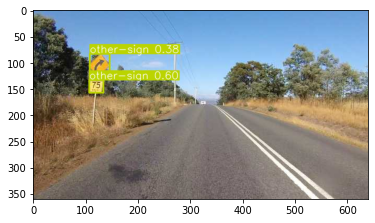

In [ ]:
%matplotlib inline
path = '/content/local_project/dataset/images/train/9yMaJd0s4lh-wcVvnO3DrQ.jpg'
img = cv2.imread(path)
result = model(img)
plt.imshow(cv2.cvtColor(np.squeeze(result.render()), cv2.COLOR_BGR2RGB))

In [ ]:
import json
import os
from PIL import Image, ImageDraw, ImageColor, ImageFont

def load_annotation(image_key):
    with open(os.path.join('mtsd_v2_fully_annotated/json_annotations', '{:s}.json'.format(image_key)), 'r') as fid:
        anno = json.load(fid)
    return anno


def visualize_gt(image_key, anno, color='green', alpha=125, font=None):
    try:
        font = ImageFont.truetype('arial.ttf', 15)
    except:
        print('Falling back to default font...')
        font = ImageFont.load_default()
    
    with Image.open(os.path.join('images_ungrouped', '{:s}.jpg'.format(image_key))) as img:
        img = img.convert('RGBA')
        img_draw = ImageDraw.Draw(img)

        rects = Image.new('RGBA', img.size)
        rects_draw = ImageDraw.Draw(rects)

        for obj in anno['objects']:
            x1 = obj['bbox']['xmin']
            y1 = obj['bbox']['ymin']
            x2 = obj['bbox']['xmax']
            y2 = obj['bbox']['ymax']

            color_tuple = ImageColor.getrgb(color)
            if len(color_tuple) == 3:
                color_tuple = color_tuple + (alpha,)
            else:
                color_tuple[-1] = alpha

            rects_draw.rectangle((x1+1, y1+1, x2-1, y2-1), fill=color_tuple)
            img_draw.line(((x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)), fill='black', width=1)

            class_name = obj['label']
            img_draw.text((x1 + 5, y1 + 5), class_name, font=font)

        img = Image.alpha_composite(img, rects)

        return img


if __name__ == '__main__':
    image_key = 'Bh36Ed4HBJatMpSNnFTgTw'

    # load the annotation json
    anno = load_annotation(image_key)

    # visualize traffic sign boxes on the image
    vis_img = visualize_gt(image_key, anno)
    vis_img.show()

Falling back to default font...





---

# Модель 1. YOLO v5 - детекция знаков










## Compress images

In [ ]:
def compress_images(source_path, destination_path, resize_rate, compress_rate):
  for file_name in os.listdir(source_path):
    if os.path.exists(destination_path + '/' + file_name):
      None
    else:
      filepath = os.path.join(source_path, file_name)
      image = Image.open(filepath)

      width = int(image.size[0]/resize_rate)
      height = int(image.size[1]/resize_rate)

      image = image.resize((width, height), Image.ANTIALIAS) #resize
      image.save(destination_path + '/' + file_name, quality=compress_rate, optimize=True) #compress and save

In [ ]:
test_source = '/content/drive/MyDrive/project/dataset/images_full/test'
train_source = '/content/drive/MyDrive/project/dataset/images_full/train'
val_source = '/content/drive/MyDrive/project/dataset/images_full/val'

test_destination = '/content/drive/MyDrive/project/dataset/images/test'
train_destination = '/content/drive/MyDrive/project/dataset/images/train'
val_destination = '/content/drive/MyDrive/project/dataset/images/val'

compress_images(val_source, val_destination, 3, 50)
compress_images(test_source, test_destination, 3, 50)
compress_images(train_source, train_destination, 3, 50)





## Copy from google drive to colab local

In [ ]:
def copy_files(source_path, destination_path):

  os.chdir(source_path)
  amount_of_files = int(sp.getoutput(f'ls -l . | wc -l'))-1 #counts number of files in a source_path
  os.chdir(destination_path)
  already_copied = int(sp.getoutput(f'ls -l . | wc -l'))-1
  print(f'Сейчас в папке {destination_path} {already_copied}/{amount_of_files} элементов')

  counter = 0
  for file_name in os.listdir(source_path):
    if os.path.exists(destination_path + '/' + file_name):
      None
    else:
      shutil.copy(source_path + '/' + file_name, destination_path + '/' + file_name)
      counter +=1
      print(f'В {destination_path} cкопировано {counter}/{amount_of_files} элементов')

In [ ]:
train_source = '/content/drive/MyDrive/project/dataset/images/train'
test_source = '/content/drive/MyDrive/project/dataset/images/test'
val_source = '/content/drive/MyDrive/project/dataset/images/val'

train_destination = '/content/local_project/dataset/images/train'
test_destination = '/content/local_project/dataset/images/test'
val_destination = '/content/local_project/dataset/images/val'

copy_files(test_source, test_destination)
copy_files(val_source, val_destination)
copy_files(train_source, train_destination)

Сейчас в папке /content/local_project/dataset/images/test 10544/10544 элементов
Сейчас в папке /content/local_project/dataset/images/val 5320/5320 элементов
Сейчас в папке /content/local_project/dataset/images/train 36589/36589 элементов


In [ ]:
!ls -l /content/local_project/dataset/labels/val | wc -l

501


In [ ]:
!find /content/local_project/dataset/images/val -type f -print0 | sort -zR | tail -zn +501 | xargs -0 rm

In [ ]:
image_path = '/content/local_project/dataset/images/train'
label_path = '/content/local_project/dataset/labels/train'

counter = 0
for file_name in os.listdir(label_path):
    if os.path.exists(image_path + '/' + file_name.split('.')[0] + '.jpg'):
      None
    else:
      os.remove(label_path + '/' + file_name)
      counter +=1
      print(f'В {label_path} удалено {counter} элементов')

Streaming output truncated to the last 5000 lines.
В /content/local_project/dataset/labels/train удалено 28590 элементов
В /content/local_project/dataset/labels/train удалено 28591 элементов
В /content/local_project/dataset/labels/train удалено 28592 элементов
В /content/local_project/dataset/labels/train удалено 28593 элементов
В /content/local_project/dataset/labels/train удалено 28594 элементов
В /content/local_project/dataset/labels/train удалено 28595 элементов
В /content/local_project/dataset/labels/train удалено 28596 элементов
В /content/local_project/dataset/labels/train удалено 28597 элементов
В /content/local_project/dataset/labels/train удалено 28598 элементов
В /content/local_project/dataset/labels/train удалено 28599 элементов
В /content/local_project/dataset/labels/train удалено 28600 элементов
В /content/local_project/dataset/labels/train удалено 28601 элементов
В /content/local_project/dataset/labels/train удалено 28602 элементов
В /content/local_project/dataset/labels

In [ ]:


найти где площадь больше Среднего
учу находить один класс - дорожный знак
обрезать баундинг бокс и подать в другую модель для классификации

## Определение топ 3000 картинок с самыми крупными знаками




In [ ]:
analysis = df[['image', 'label', 'xmin', 'ymin', 'xmax', 'ymax']]

In [ ]:
analysis['bbwidth'] = analysis['xmax'].sub(analysis['xmin'])
analysis['bbheight'] = analysis['ymax'].sub(analysis['ymin'])
analysis['bbsquare'] = analysis['bbwidth']*analysis['bbheight']

<ipython-input-33-b591b602928d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['bbwidth'] = analysis['xmax'].sub(analysis['xmin'])
<ipython-input-33-b591b602928d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['bbheight'] = analysis['ymax'].sub(analysis['ymin'])
<ipython-input-33-b591b602928d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [ ]:
largest3000 = analysis.pivot_table(index='image', values='bbsquare', aggfunc='max').sort_values('bbsquare', ascending=False).head(3000)

## Выборка соответствующего датасета


In [ ]:
ls -l /content/drive/MyDrive/project/dataset/images_full | wc -l

52457


In [ ]:
source_path = '/content/drive/MyDrive/project/dataset/images_full'
!mkdir /content/drive/MyDrive/project/dataset/images_for_model1
destination_path = '/content/drive/MyDrive/project/dataset/images_for_model1'

counter_source = 0
for file_name in os.listdir(source_path):
  counter_source += 1
  print(f'counter_source = {counter_source}')
  for i in largest3000_list:
    counter_destination += 1
    if file_name.split('.')[0] == i and not os.path.exists(os.path.join(destination_path, file_name)):
      filepath = os.path.join(source_path, file_name)
      image = Image.open(filepath)
      width = int(image.size[0]/2)
      height = int(image.size[1]/2)
      image = image.resize((width, height), Image.ANTIALIAS) #resize
      image.save(destination_path + '/' + file_name, quality=50, optimize=True) #compress and save

In [ ]:
ls -l /content/drive/MyDrive/project/dataset/images_for_model1 | wc -l

3001



## Выборка лейблов



In [ ]:
df_yolo1 = df_yolo.merge(pd.Series(largest3000.index), on='image', how='right')
df_yolo1.loc[:, 'class'] = 0
df_yolo1

,image,class,xc,yc,w,h
0,kR0ySu_Eg6_gertGWgJbfg,0,0.525513,0.643433,0.079346,0.061768
1,kR0ySu_Eg6_gertGWgJbfg,0,0.439941,0.641846,0.080078,0.059570
2,kR0ySu_Eg6_gertGWgJbfg,0,0.354858,0.640625,0.079834,0.060547
3,kR0ySu_Eg6_gertGWgJbfg,0,0.485962,0.302856,0.237549,0.182861
4,kR0ySu_Eg6_gertGWgJbfg,0,0.478760,0.653320,0.438965,0.487305
...,...,...,...,...,...,...
20373,ZRufXWoZJDMVOeh3v7XyOw,0,0.539307,0.659790,0.008301,0.013916
20374,ZRufXWoZJDMVOeh3v7XyOw,0,0.889038,0.766602,0.055420,0.094238
20375,ZRufXWoZJDMVOeh3v7XyOw,0,0.305054,0.664795,0.007568,0.016602
20376,ZRufXWoZJDMVOeh3v7XyOw,0,0.442383,0.686523,0.003906,0.006348


In [ ]:
output_dir = pathlib.Path('/content/drive/MyDrive/project/model1/labels') 

for image_name, group in df_yolo1.groupby('image'):
    path = output_dir / f'{image_name}.txt'

    # If there are annotations for this image, dump them into the file
    if (group['class'] != -1).any():
        group.drop('image', axis=1).to_csv(path, sep=' ', header=False, index=False)
    else:
        path.touch()  # Create empty file

print(len(list(output_dir.glob('*.txt'))), 'txt files in output directory')

3000 txt files in output directory


## Переходим на GPU и копируем датасет на локальное пространство colab






In [ ]:
!cp -r /content/drive/MyDrive/project/model1 /content

## Запускаем обучение yolo





In [ ]:
%%bash
cd /content/drive/MyDrive/project/yolov5
pip install -r requirements.txt  

In [ ]:
%%bash
cd /content/drive/MyDrive/project/yolov5
python train.py --img 640 --batch 32 --epochs 50 --data model1_data.yaml --cfg model1_cfg.yaml --weights yolov5s.pt 

train: weights=yolov5s.pt, cfg=model1_cfg.yaml, data=model1_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv

In [ ]:
!cp /content/drive/MyDrive/project/yolov5/models/yolov5s.yaml /content/drive/MyDrive/project/yolov5/model1_cfg.yaml

## Проверка результатов обучения






In [ ]:
model = torch.hub.load('ultralytics/yolov5', 
                       'custom', 
                       path='/content/drive/MyDrive/project/yolov5/runs/train/exp50/weights/best.pt', 
                       force_reload=True)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython" "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB

In [ ]:
urllib.request.urlretrieve("https://cdn1.matadornetwork.com/blogs/1/2022/08/social-road-signs-and-meanings.jpeg", "image2.jpg")

('image2.jpg', <http.client.HTTPMessage at 0x7fca8bfea3d0>)

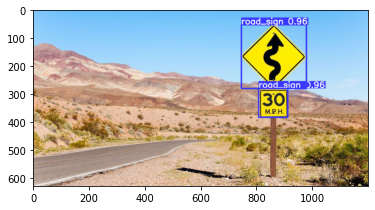

In [ ]:
%matplotlib inline
path = '/content/image2.jpg'
img = cv2.imread(path)
result = model(img)
plt.imshow(cv2.cvtColor(np.squeeze(result.render()), cv2.COLOR_BGR2RGB))

In [ ]:
crops = result.crop(save=True)

Saved 1 image to runs/detect/exp4
Saved results to runs/detect/exp4




---

# Модель 2. ResNet50 - классификация знаков






In [ ]:
#cp -r /content/drive/MyDrive/project/model2 /content
#!zip -r model2.zip /content/model2

In [ ]:
!cp /content/drive/MyDrive/project/model2.zip /content/model2.zip
!unzip /content/model2.zip -d .
!mv /content/content/model2 /content
!rm -r /content/content 
!rm /content/model2.zip

In [ ]:
# specify the directories to check
dir1 = '/content/model2/train'
dir2 = '/content/model2/val'

# get the list of subfolders in each directory
subfolders1 = [f.name for f in os.scandir(dir1) if f.is_dir()]
subfolders2 = [f.name for f in os.scandir(dir2) if f.is_dir()]

# check for subfolders that exist in one directory but not the other
for subfolder in subfolders1:
    print(subfolder)
    if subfolder not in subfolders2:
        shutil.rmtree('/content/model2/train/'+subfolder)

In [ ]:
model2_df = pd.read_excel('/content/drive/MyDrive/project/Data for model 2 (ETSD)/edited_Classes_Description.xlsx')
model2_df['class'] = model2_df['class'].astype('int')
model2_df

,class,descriptive,category
0,1,Right bend,Dangerous warning
1,2,Left bend,Dangerous warning
2,3,Double bend (left),Dangerous warning
3,4,Double bend (right),Dangerous warning
4,5,Dangerous descent,Dangerous warning
...,...,...,...
159,160,Limited access on side,Others
160,161,Curve right,Others
161,162,Curve left,Others
162,163,Barrier,Others


In [ ]:
labels = model2_df['class']

In [ ]:
#NUMBER_OF_CLASSES = model2_df['class'].nunique()
NUMBER_OF_CLASSES = 102

In [ ]:
dir = '/content/model2/val'
len([f.path for f in os.scandir(dir) if f.is_dir()])

102

In [ ]:
# #delete all files containing .csv 
# for subdir, dirs, files in os.walk('/content/drive/MyDrive/project/model2'):
#     for file in files:
#         filepath = subdir + os.sep + file
#         if filepath.endswith(".csv"):
#             os.remove(filepath)
#             print(f"file {filepath} deleted")
#     for dir in dirs:
#         if dir.endswith(".ipynb_checkpoints"):
#             dirpath = subdir + os.sep + dir
#             shutil.rmtree(dirpath)
#             print(f"folder {dirpath} deleted")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
train_dataset = torchvision.datasets.ImageFolder('/content/model2/train',
                                                 transform=T.Compose([T.Resize((256, 256)),
                                                                      T.ToTensor()]))
valid_dataset = torchvision.datasets.ImageFolder('/content/model2/val',
                                                 transform=T.Compose([T.Resize((256, 256)),
                                                                      T.ToTensor()]))

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=32)

In [ ]:
weights=ResNet50_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
model = resnet50(weights=weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Unfreeze last Bottleneck
model.layer4[2].conv1.weight.requires_grad = True

model.layer4[2].bn1.weight.requires_grad = True
model.layer4[2].bn1.bias.requires_grad = True

model.layer4[2].conv2.weight.requires_grad = True

model.layer4[2].bn2.weight.requires_grad = True
model.layer4[2].bn2.bias.requires_grad = True

model.layer4[2].conv3.weight.requires_grad = True

model.layer4[2].bn3.weight.requires_grad = True
model.layer4[2].bn3.bias.requires_grad = True

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

# Set out_features = total number of classes in the dataset
model.fc = nn.Linear(in_features=2048, out_features=NUMBER_OF_CLASSES, bias=True)

In [ ]:
# Check
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
summary(model.to(device), (3, 224, 224), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,408
       BatchNorm2d-2         [64, 64, 112, 112]             128
              ReLU-3         [64, 64, 112, 112]               0
         MaxPool2d-4           [64, 64, 56, 56]               0
            Conv2d-5           [64, 64, 56, 56]           4,096
       BatchNorm2d-6           [64, 64, 56, 56]             128
              ReLU-7           [64, 64, 56, 56]               0
            Conv2d-8           [64, 64, 56, 56]          36,864
       BatchNorm2d-9           [64, 64, 56, 56]             128
             ReLU-10           [64, 64, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]          16,384
      BatchNorm2d-12          [64, 256, 56, 56]             512
           Conv2d-13          [64, 256, 56, 56]          16,384
      BatchNorm2d-14          [64, 256,

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def compute_batch_accuracy(preds, labels):
    preds_softmax  = torch.nn.functional.softmax(preds, dim = 1)
    preds_classes  = preds_softmax.argmax(1)
    array     = preds_classes == labels
    number_of_true = array.sum()
    accuracy       = number_of_true / len(labels)
    accuracy_float = accuracy.item()
    return accuracy_float

[Epoch 0] Train loss: 0.6522, valid loss = 0.3332 Train acc 0.8173 Valid acc 0.8201
[Epoch 1] Train loss: 0.2246, valid loss = 0.0480 Train acc 0.9319 Valid acc 0.8361
[Epoch 2] Train loss: 0.1447, valid loss = 0.3705 Train acc 0.9554 Valid acc 0.8607
[Epoch 3] Train loss: 0.1076, valid loss = 0.0365 Train acc 0.9667 Valid acc 0.8665
[Epoch 4] Train loss: 0.0820, valid loss = 0.0991 Train acc 0.9747 Valid acc 0.8730
[Epoch 5] Train loss: 0.0656, valid loss = 0.0100 Train acc 0.9797 Valid acc 0.8671
[Epoch 6] Train loss: 0.0558, valid loss = 0.0461 Train acc 0.9830 Valid acc 0.8709
[Epoch 7] Train loss: 0.0454, valid loss = 0.0252 Train acc 0.9863 Valid acc 0.8716
[Epoch 8] Train loss: 0.0419, valid loss = 0.0256 Train acc 0.9877 Valid acc 0.8787
[Epoch 9] Train loss: 0.0349, valid loss = 0.0028 Train acc 0.9894 Valid acc 0.8832


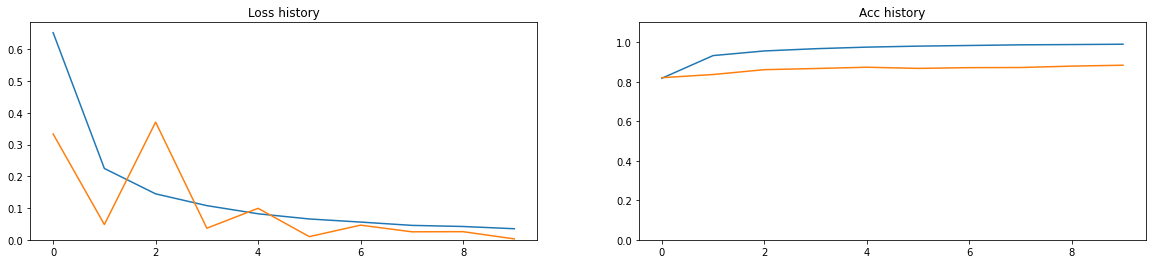

In [ ]:

model.to(device)

train_epoch_losses = []
valid_epoch_losses = []


train_epoch_acc = []
valid_epoch_acc = []

for epoch in range(10):
  model.train()
  loss_batch = []
  acc_batch = []

  for images, labels in train_loader:

    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)

    loss = criterion(preds, labels)

    loss_batch.append(loss.item())
    acc_batch.append(compute_batch_accuracy(preds, labels))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_epoch_losses.append(np.mean(loss_batch))
  train_epoch_acc.append(np.mean(acc_batch))

  model.eval()
  loss_batch = []
  acc_batch = []

  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)

    loss_batch.append(loss.item())
    acc_batch.append(compute_batch_accuracy(preds, labels))

  valid_epoch_losses.append(np.mean(loss_batch))
  valid_epoch_acc.append(np.mean(acc_batch))
  print(f'[Epoch {epoch}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_epoch_losses)
ax[0].plot(valid_epoch_losses)
ax[0].set_ylim((0, np.max(train_epoch_losses.extend(valid_epoch_losses))))
ax[0].set_title('Loss history')

ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history');

In [ ]:
torch.save(model.state_dict(), '/content/weights2.pt')
#model.load_state_dict(torch.load('/content/weights.pt'))

In [ ]:
cp /content/weights2.pt /content/drive/MyDrive/project

In [ ]:
urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSU4dTq-HSRU5TFKlacJ-URKqZU6uaRkYH_Ez-7AbTSFd2eXdEew_YHiTRyd0tStFQCnHY&usqp=CAU", "image5.jpg")


('image5.jpg', <http.client.HTTPMessage at 0x7f080b0e8580>)

In [ ]:
model.eval()
transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])  # Same as for your validation data, e.g. Resize, ToTensor, Normalize, ...

img = Image.open('/content/image5.jpg')  # Load image as PIL.Image
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension

output = model(x.to(device))  # Forward pass

pred = torch.argmax(output, 1)  # Get predicted class if multi-class classification
print('Image predicted as ', pred)

RuntimeError: ignored







---


# Модель 3. Своя сеть (не использовал)




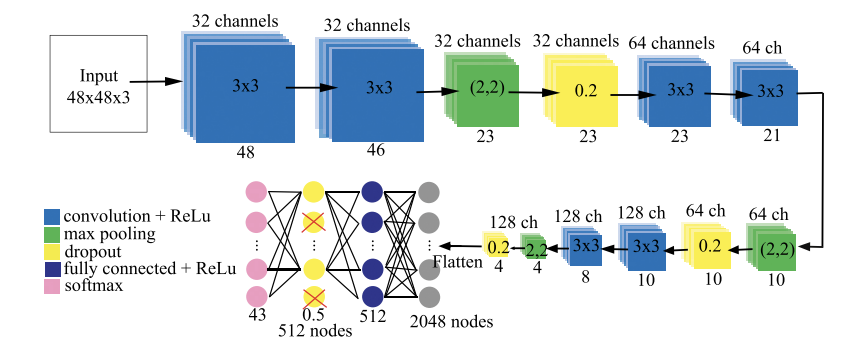

In [ ]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, 
                                              out_channels=32, 
                                              kernel_size=3,
                                              padding=1), 
                                    nn.ReLU()) 

        self.layer2 = nn.Sequential(nn.Conv2d(32, 32, 
                                              kernel_size=3), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 

        self.drop_out = nn.Dropout(p=0.2)

        self.layer3 = nn.Sequential(nn.Conv2d(32, 64, 
                                              kernel_size=3, 
                                              padding=1), 
                                    nn.ReLU()) 
        self.layer4 = nn.Sequential(nn.Conv2d(64, 64, 
                                              kernel_size=3), 
                                    nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer5 = nn.Sequential(nn.Conv2d(64, 128, 
                                              kernel_size=3, 
                                              padding=1), 
                                    nn.ReLU()) 
        self.layer6 = nn.Sequential(nn.Conv2d(128, 128, 
                                              kernel_size=3), 
                                    nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer7 = nn.Sequential(nn.Flatten(), 
                                     nn.Linear(2048, 512))
        self.fc = nn.Linear(512, 164)
        
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.drop_out(out) 
        out = self.layer3(out) 
        out = self.layer4(out) 
        out = self.drop_out(out) 
        out = self.layer5(out) 
        out = self.layer6(out) 
        out = self.drop_out(out) 
        out = self.layer7(out) 
        out = self.drop_out(out) 
        out = self.fc(out)
        return out
    
model = CNN()

In [ ]:
summary(model.to(device), (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 32, 46, 46]           9,248
              ReLU-4           [-1, 32, 46, 46]               0
         MaxPool2d-5           [-1, 32, 23, 23]               0
           Dropout-6           [-1, 32, 23, 23]               0
            Conv2d-7           [-1, 64, 23, 23]          18,496
              ReLU-8           [-1, 64, 23, 23]               0
            Conv2d-9           [-1, 64, 21, 21]          36,928
             ReLU-10           [-1, 64, 21, 21]               0
        MaxPool2d-11           [-1, 64, 10, 10]               0
          Dropout-12           [-1, 64, 10, 10]               0
           Conv2d-13          [-1, 128, 10, 10]          73,856
             ReLU-14          [-1, 128,

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('/content/model2/train',
                                                 transform=T.Compose([T.Resize((48, 48)),
                                                                      T.ToTensor()]))
valid_dataset = torchvision.datasets.ImageFolder('/content/model2/val',
                                                 transform=T.Compose([T.Resize((48, 48)),
                                                                      T.ToTensor()]))

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=256)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def compute_batch_accuracy(preds, labels):
    preds_softmax  = torch.nn.functional.softmax(preds, dim = 1)
    preds_classes  = preds_softmax.argmax(1)
    array     = preds_classes == labels
    number_of_true = array.sum()
    accuracy       = number_of_true / len(labels)
    accuracy_float = accuracy.item()
    return accuracy_float

[Epoch 0] Train loss: 0.7956, valid loss = 0.6357 Train acc 0.7789 Valid acc 0.8063
[Epoch 1] Train loss: 0.7158, valid loss = 0.7793 Train acc 0.7989 Valid acc 0.8157
[Epoch 2] Train loss: 0.7115, valid loss = 0.6775 Train acc 0.7992 Valid acc 0.8196
[Epoch 3] Train loss: 0.6642, valid loss = 0.7461 Train acc 0.8121 Valid acc 0.8140
[Epoch 4] Train loss: 0.6541, valid loss = 0.5479 Train acc 0.8152 Valid acc 0.8267
[Epoch 5] Train loss: 0.6359, valid loss = 0.5872 Train acc 0.8195 Valid acc 0.8175
[Epoch 6] Train loss: 0.6143, valid loss = 0.5714 Train acc 0.8244 Valid acc 0.8230
[Epoch 7] Train loss: 0.6161, valid loss = 0.6592 Train acc 0.8252 Valid acc 0.8285
[Epoch 8] Train loss: 0.6316, valid loss = 0.5291 Train acc 0.8199 Valid acc 0.8189
[Epoch 9] Train loss: 0.5938, valid loss = 0.7248 Train acc 0.8297 Valid acc 0.8202


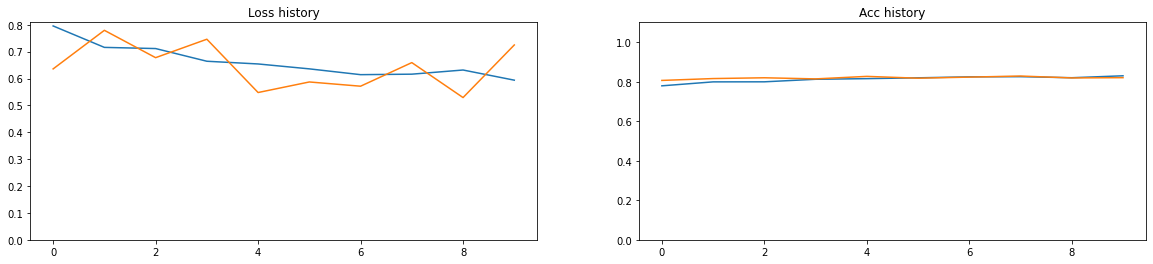

In [ ]:

model.to(device)

train_epoch_losses = []
valid_epoch_losses = []


train_epoch_acc = []
valid_epoch_acc = []

for epoch in range(10):
  model.train()
  loss_batch = []
  acc_batch = []

  for images, labels in train_loader:

    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)

    loss = criterion(preds, labels)

    loss_batch.append(loss.item())
    acc_batch.append(compute_batch_accuracy(preds, labels))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_epoch_losses.append(np.mean(loss_batch))
  train_epoch_acc.append(np.mean(acc_batch))

  model.eval()
  loss_batch = []
  acc_batch = []

  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)

    loss_batch.append(loss.item())
    acc_batch.append(compute_batch_accuracy(preds, labels))

  valid_epoch_losses.append(np.mean(loss_batch))
  valid_epoch_acc.append(np.mean(acc_batch))
  print(f'[Epoch {epoch}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_epoch_losses)
ax[0].plot(valid_epoch_losses)
ax[0].set_ylim((0, np.max(train_epoch_losses.extend(valid_epoch_losses))))
ax[0].set_title('Loss history')

ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history');

In [ ]:
!kill 0



---


# Модель 4. ResNet50 c другим датасетом (не использовал)






In [ ]:
!cp /content/drive/MyDrive/project/dataset3.zip /content/dataset3.zip
!unzip /content/dataset3.zip -d .
!mv '/content/content/dataset3 (GTSRB)' /content
!rm -r /content/content 
!rm /content/dataset3.zip
!rm -r '/content/dataset3 (GTSRB)/val/Images'
!rm '/content/dataset3 (GTSRB)/val/Readme.txt'

Streaming output truncated to the last 5000 lines.
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00011_00028.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00010_00020.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00000_00016.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00011_00013.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00013_00010.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00010_00023.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00002_00008.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00002_00003.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00003_00011.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00008_00017.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00002_00004.ppm  
  inflating: ./content/dataset3 (GTSRB)/train/Images/00023/00013_00024.ppm  
  inflating: ./content/da

In [ ]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, 
                                              out_channels=32, 
                                              kernel_size=3,
                                              padding=1), 
                                    nn.ReLU()) 

        self.layer2 = nn.Sequential(nn.Conv2d(32, 32, 
                                              kernel_size=3), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 

        self.drop_out = nn.Dropout(p=0.2)

        self.layer3 = nn.Sequential(nn.Conv2d(32, 64, 
                                              kernel_size=3, 
                                              padding=1), 
                                    nn.ReLU()) 
        self.layer4 = nn.Sequential(nn.Conv2d(64, 64, 
                                              kernel_size=3), 
                                    nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer5 = nn.Sequential(nn.Conv2d(64, 128, 
                                              kernel_size=3, 
                                              padding=1), 
                                    nn.ReLU()) 
        self.layer6 = nn.Sequential(nn.Conv2d(128, 128, 
                                              kernel_size=3), 
                                    nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer7 = nn.Sequential(nn.Flatten(), 
                                     nn.Linear(2048, 512))
        self.fc = nn.Linear(512, 43)
        
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.drop_out(out) 
        out = self.layer3(out) 
        out = self.layer4(out) 
        out = self.drop_out(out) 
        out = self.layer5(out) 
        out = self.layer6(out) 
        out = self.drop_out(out) 
        out = self.layer7(out) 
        out = self.drop_out(out) 
        out = self.fc(out)
        return out
    
model = CNN()

In [ ]:
summary(model.to(device), (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 32, 46, 46]           9,248
              ReLU-4           [-1, 32, 46, 46]               0
         MaxPool2d-5           [-1, 32, 23, 23]               0
           Dropout-6           [-1, 32, 23, 23]               0
            Conv2d-7           [-1, 64, 23, 23]          18,496
              ReLU-8           [-1, 64, 23, 23]               0
            Conv2d-9           [-1, 64, 21, 21]          36,928
             ReLU-10           [-1, 64, 21, 21]               0
        MaxPool2d-11           [-1, 64, 10, 10]               0
          Dropout-12           [-1, 64, 10, 10]               0
           Conv2d-13          [-1, 128, 10, 10]          73,856
             ReLU-14          [-1, 128,

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('/content/dataset3 (GTSRB)/train',
                                                 transform=T.Compose([T.Resize((48, 48)),
                                                                      T.ToTensor()]))
valid_dataset = torchvision.datasets.ImageFolder('/content/dataset3 (GTSRB)/val',
                                                 transform=T.Compose([T.Resize((48, 48)),
                                                                      T.ToTensor()]))

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=256)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def compute_batch_accuracy(preds, labels):
    preds_softmax  = torch.nn.functional.softmax(preds, dim = 1)
    preds_classes  = preds_softmax.argmax(1)
    array     = preds_classes == labels
    number_of_true = array.sum()
    accuracy       = number_of_true / len(labels)
    accuracy_float = accuracy.item()
    return accuracy_float

In [ ]:

model.to(device)

train_epoch_losses = []
valid_epoch_losses = []


train_epoch_acc = []
valid_epoch_acc = []

for epoch in range(5):
  model.train()
  loss_batch = []
  acc_batch = []

  for images, labels in train_loader:

    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)

    loss = criterion(preds, labels)

    loss_batch.append(loss.item())
    acc_batch.append(compute_batch_accuracy(preds, labels))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_epoch_losses.append(np.mean(loss_batch))
  train_epoch_acc.append(np.mean(acc_batch))

  model.eval()
  loss_batch = []
  acc_batch = []

  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)

    loss_batch.append(loss.item())
    acc_batch.append(compute_batch_accuracy(preds, labels))

  valid_epoch_losses.append(np.mean(loss_batch))
  valid_epoch_acc.append(np.mean(acc_batch))
  print(f'[Epoch {epoch}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_epoch_losses)
ax[0].plot(valid_epoch_losses)
ax[0].set_ylim((0, np.max(train_epoch_losses.extend(valid_epoch_losses))))
ax[0].set_title('Loss history')

ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history');

[Epoch 0] Train loss: 2.8514, valid loss = 1.1814 Train acc 0.2068 Valid acc 0.5933
[Epoch 1] Train loss: 0.5521, valid loss = 0.1403 Train acc 0.8214 Valid acc 0.9578
[Epoch 2] Train loss: 0.1513, valid loss = 0.2100 Train acc 0.9536 Valid acc 0.9858
[Epoch 3] Train loss: 0.0849, valid loss = 0.0122 Train acc 0.9742 Valid acc 0.9941
[Epoch 4] Train loss: 0.0524, valid loss = 0.0277 Train acc 0.9841 Valid acc 0.9968
[Epoch 5] Train loss: 0.0404, valid loss = 0.0090 Train acc 0.9870 Valid acc 0.9972
[Epoch 6] Train loss: 0.0338, valid loss = 0.0300 Train acc 0.9886 Valid acc 0.9971
[Epoch 7] Train loss: 0.0311, valid loss = 0.0078 Train acc 0.9906 Valid acc 0.9993


KeyboardInterrupt: ignored

In [ ]:
urllib.request.urlretrieve("https://media.istockphoto.com/id/529371821/vector/traffic-road-sign-vector.jpg?s=612x612&w=0&k=20&c=Hzt-7g0bHL80MPyoB2HT0XNMMP-kxWACzDzlpk9_58k=", "image5.jpg")


('image5.jpg', <http.client.HTTPMessage at 0x7f080810f7f0>)

In [ ]:
model.eval()
transform = T.Compose([T.Resize((48, 48)), T.ToTensor()])  # Same as for your validation data, e.g. Resize, ToTensor, Normalize, ...

img = Image.open('/content/image5.jpg')  # Load image as PIL.Image
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension

output = model(x.to(device))  # Forward pass

pred = torch.argmax(output, 1)  # Get predicted class if multi-class classification
print('Image predicted as ', pred)

Image predicted as  tensor([14], device='cuda:0')
